## Dilated TCN - Credit Card Anomaly Detection
#### Version 5 with PCA Dimension Reduction and model from v2

##### Import libraries and packages 

In [1]:
import keras
from keras import regularizers, optimizers
from keras import losses
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Input, Dropout, Embedding, LSTM
from keras.optimizers import RMSprop, Adam, Nadam
from keras.preprocessing import sequence

from keras.layers import Conv1D, Flatten, Activation, SpatialDropout1D
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.utils import to_categorical

import sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.metrics import classification_report

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

import tensorflow 
import sys

## Print to screen the software versions.... 
print("Python: ", sys.version)

print("pandas: ", pd.__version__)
print("numpy: ", np.__version__)
print("seaborn: ", sns.__version__)
print("matplotlib: ", matplotlib.__version__)
print("sklearn: ", sklearn.__version__)
print("Keras: ", keras.__version__)
print("Tensorflow: ", tensorflow.__version__)




Python:  3.11.6 (tags/v3.11.6:8b6ee5b, Oct  2 2023, 14:57:12) [MSC v.1935 64 bit (AMD64)]
pandas:  2.1.1
numpy:  1.26.1
seaborn:  0.13.0
matplotlib:  3.8.0
sklearn:  1.3.1
Keras:  2.14.0
Tensorflow:  2.14.0


##### Visualisation Class - for confusion matrix and plot Anomalies 

In [2]:
class Visualization:
    labels = ["Normal", "Anomaly"]

    def draw_confusion_matrix(self, y, ypred):
        matrix = confusion_matrix(y, ypred)

        plt.figure(figsize=(10, 8))
        colors=[ "orange","green"]
        sns.heatmap(matrix, xticklabels=self.labels, yticklabels=self.labels, cmap=colors, annot=True, fmt="d")
        plt.title("Confusion Matrix")
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.show()


    def draw_anomaly(self, y, error, threshold):
        groupsDF = pd.DataFrame({'error': error,
                                 'true': y}).groupby('true')

        figure, axes = plt.subplots(figsize=(12, 8))

        for name, group in groupsDF:
            axes.plot(group.index, group.error, marker='x' if name == 1 else 'o', linestyle='',
                    color='r' if name == 1 else 'g', label="Anomaly" if name == 1 else "Normal")

        axes.hlines(threshold, axes.get_xlim()[0], axes.get_xlim()[1], colors="b", zorder=100, label='Threshold')
        axes.legend()
        
        plt.title("Anomalies")
        plt.ylabel("Error")
        plt.xlabel("Data")
        plt.show()

    def draw_error(self, error, threshold):
            plt.plot(error, marker='o', ms=3.5, linestyle='',
                     label='Point')

            plt.hlines(threshold, xmin=0, xmax=len(error)-1, colors="b", zorder=100, label='Threshold')
            plt.legend()
            plt.title("Reconstruction error")
            plt.ylabel("Error")
            plt.xlabel("Data")
            plt.show()

##### Import csv file 

In [3]:
df = pd.read_csv("data/creditcard.csv", sep=",", index_col=None)
print(df.shape)
df.head()

(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
df.tail()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0
284806,172792.0,-0.533413,-0.189733,0.703337,-0.506271,-0.012546,-0.649617,1.577006,-0.414650,0.486180,...,0.261057,0.643078,0.376777,0.008797,-0.473649,-0.818267,-0.002415,0.013649,217.00,0


##### Standardise Time and Amount values 

In [5]:
df['Amount'] = StandardScaler().fit_transform(df['Amount'].values.reshape(-1, 1))
df['Time'] = StandardScaler().fit_transform(df['Time'].values.reshape(-1, 1))
df.tail()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
284802,1.641931,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,-0.350151,0
284803,1.641952,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,-0.254117,0
284804,1.641974,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,-0.081839,0
284805,1.641974,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,-0.313249,0
284806,1.642058,-0.533413,-0.189733,0.703337,-0.506271,-0.012546,-0.649617,1.577006,-0.414650,0.486180,...,0.261057,0.643078,0.376777,0.008797,-0.473649,-0.818267,-0.002415,0.013649,0.514355,0


##### Create 2 dataframes - one with classified normal data, and one with classified anomalies  

In [6]:
anomalies = df[df["Class"] == 1]
normal = df[df["Class"] == 0]

anomalies.shape, normal.shape


((492, 31), (284315, 31))

Note - their are only 492 anomalies in the data - about 0.173% of the data

In [7]:
import matplotlib.pyplot as plt
import plotly.express as px

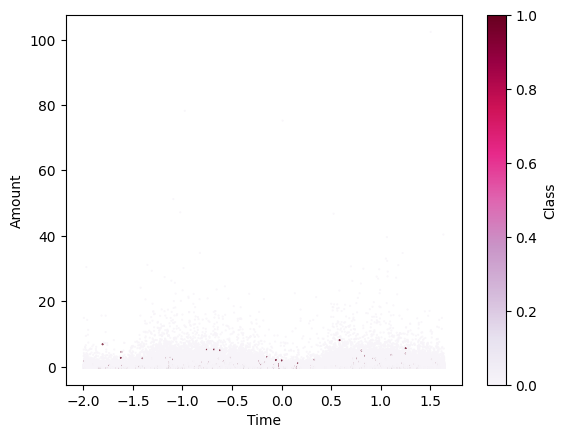

In [8]:
# plt.scatter(df['Time'] ,df['Amount'], s=0.2, c=df['Class'], cmap='PuRd')
# plt.colorbar()
# ax = plt.axes()
# ax.set_facecolor("yellow")
# plt.show()
ax1 = df.plot.scatter(x='Time', y='Amount', s=0.2, c='Class', cmap='PuRd', facecolor='yellow')


In [ ]:
### Try plotly ..... too many points for plotly 
fig = px.scatter(df, x='Time', y='Amount', color='class')
fig.show()

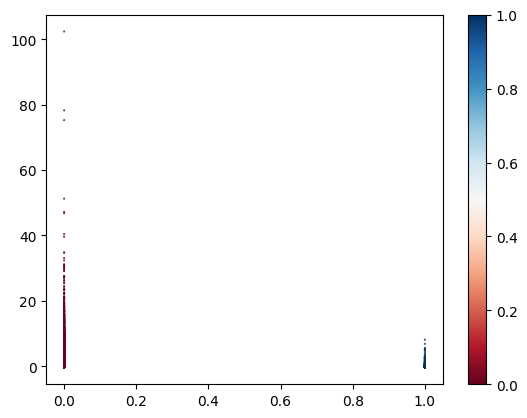

In [54]:
plt.scatter(df['Class'] ,df['Amount'], s=0.2, c=df['Class'], cmap='RdBu')
plt.colorbar()
# ax = plt.axes()
# ax.set_facecolor("yellow")
plt.show()

### Use PCA dimension reduction  

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [10]:
## Seperate the x-y values from the concentrations....
## Treat x-y as our input variables:  
dfY = df[['Time','Class']].copy()
dfX = df[['V1','V2', 'V3', 'V4', 'V5', 'V6','V7', 'V8', 'V9', 'V10', 'V11','V12', 'V13', 'V14', 'V15', 'V16','V17', 'V18', 'V19', 'V20', 'V21','V22', 'V23', 'V24', 'V25', 'V26','V27', 'V28', 'Amount' ]].copy()

In [19]:
dfX.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.244964
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.342475
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,1.160686
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.140534
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,-0.073403


##### V1-V28 have been standardised with a mean of zero - while Amount is now standardised. However, anomalies are still in the data. 

In [20]:
### Function to calculate the variance for each number of PCA principle components:

def get_variance(X, n):
    scaler = StandardScaler()
    pca = PCA(n_components=n)
    ## pca.fit(scaler.fit_transform(X))
    pca.fit((X))
    return pca.explained_variance_ratio_.cumsum()[-1:]


In [21]:
## Print the cumilative variance across 29 PCs 
for i in range(1,30):
    print('Components:\t', i, '=\t', get_variance(dfX, i), 
          '\tCumulative Variance')

Components:	 1 =	 [0.12417222] 	Cumulative Variance
Components:	 2 =	 [0.22346641] 	Cumulative Variance
Components:	 3 =	 [0.29730233] 	Cumulative Variance
Components:	 4 =	 [0.36261956] 	Cumulative Variance
Components:	 5 =	 [0.42534085] 	Cumulative Variance
Components:	 6 =	 [0.48210279] 	Cumulative Variance
Components:	 7 =	 [0.53296344] 	Cumulative Variance
Components:	 8 =	 [0.5780142] 	Cumulative Variance
Components:	 9 =	 [0.61601817] 	Cumulative Variance
Components:	 10 =	 [0.65360701] 	Cumulative Variance
Components:	 11 =	 [0.68649846] 	Cumulative Variance
Components:	 12 =	 [0.71795358] 	Cumulative Variance
Components:	 13 =	 [0.7491826] 	Cumulative Variance
Components:	 14 =	 [0.77817217] 	Cumulative Variance
Components:	 15 =	 [0.80458132] 	Cumulative Variance
Components:	 16 =	 [0.8287796] 	Cumulative Variance
Components:	 17 =	 [0.85151806] 	Cumulative Variance
Components:	 18 =	 [0.87381225] 	Cumulative Variance
Components:	 19 =	 [0.89543172] 	Cumulative Variance
Compo

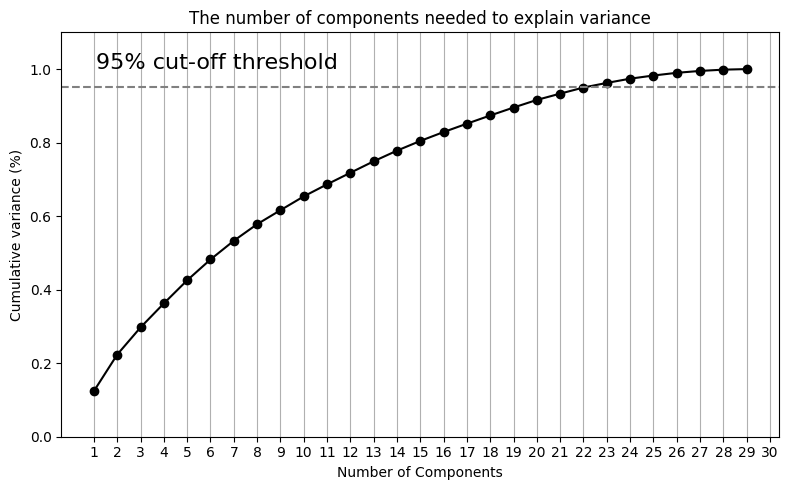

In [22]:
### Show this informaion in graphical form - with a 95% cutoff

scaler = StandardScaler()
data_rescaled = scaler.fit_transform(dfX)

## pca = PCA().fit(data_rescaled)
pca = PCA().fit(dfX)

plt.rcParams["figure.figsize"] = (8,5)

fig, ax = plt.subplots()
xi = np.arange(1, 30, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='-', color='black')

plt.xlabel('Number of Components')
plt.xticks(np.arange(1, 31, step=1)) 
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='grey', linestyle='--')
plt.text(1.1, 1, '95% cut-off threshold', color = 'black', fontsize=16)

ax.grid(axis='x')
plt.tight_layout()
plt.savefig('pcavisualize_1.png', dpi=300)
plt.show()

#### Data has obviously been created in such a way as to avoid PCA dim reduction - none of the dimensions have much more variance than the others :( 
    Could try to reduce the dimensions to 22  

In [24]:
### Define function for the PCA fit and inverse transform: 
def transform_pca(X, n):

    pca = PCA(n_components=n)
    pca.fit(X)
    X_new = pca.inverse_transform(pca.transform(X))

    return X_new

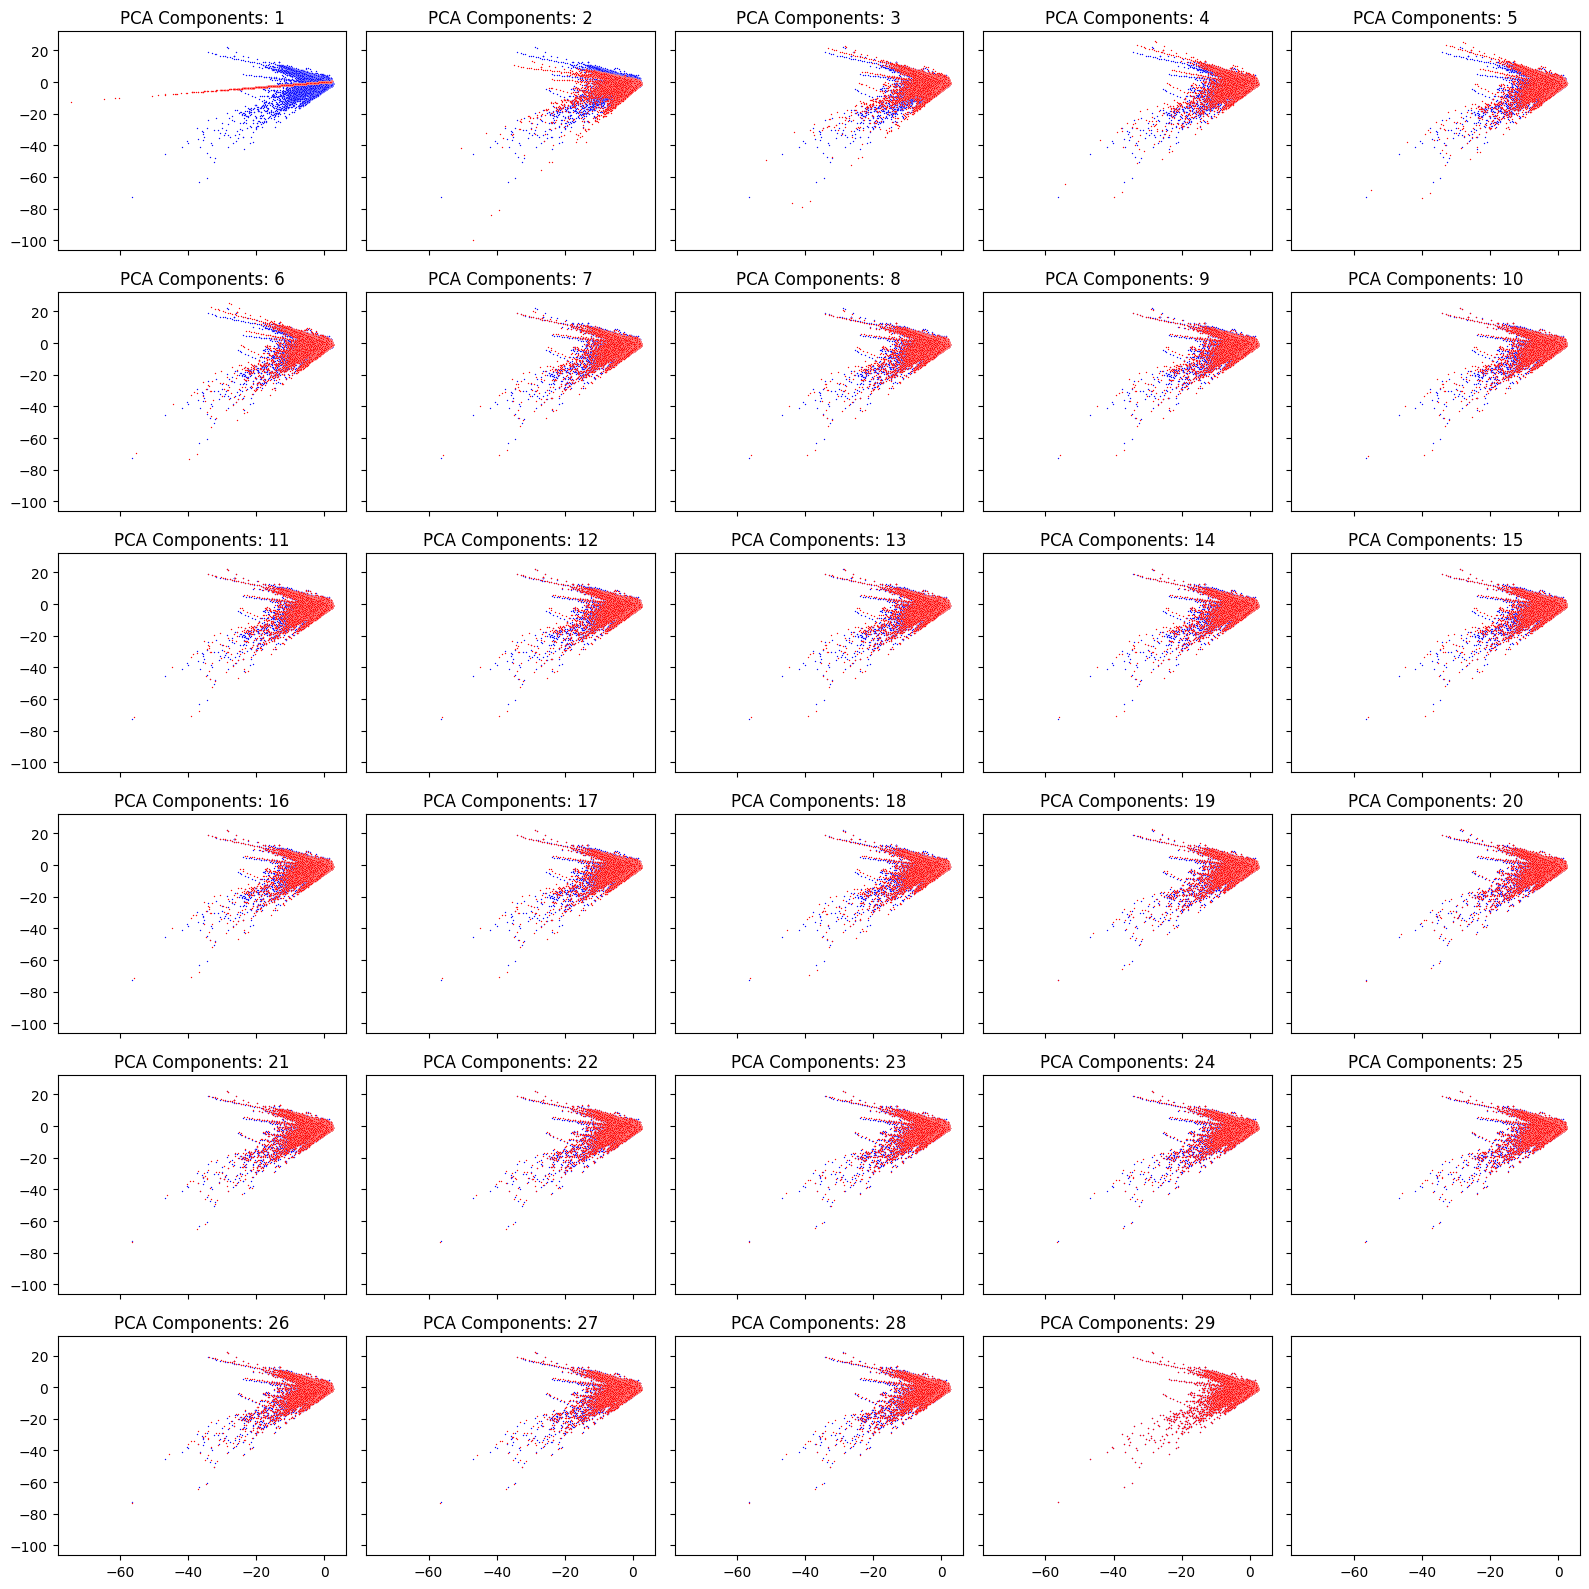

In [27]:
### Visualise the original data overlayered against the PCA inverse transform data:
## Define view parameters
rows = 6
cols = 5
comps = 1

## scaler = StandardScaler()
X_scaled = dfX.to_numpy()

fig, axes = plt.subplots(rows, 
                         cols, 
                         figsize=(16,16), 
                         sharex=True, 
                         sharey=True)

# Scatter of PCA (Black) and original (grey)  
for row in range(rows):
    for col in range(cols):
        try:
            X_new = transform_pca(X_scaled, comps)
            ax = sns.scatterplot(x=X_scaled[:, 0], 
                                 y=X_scaled[:, 1], 
                                 ax=axes[row, col], 
                                 color='blue', 
                                 s=1)
            ax = sns.scatterplot(x=X_new[:, 0], 
                                 y=X_new[:, 1], 
                                 ax=axes[row, col], 
                                 color='red',
                                 s=1)
            ax.set_title(f'PCA Components: {comps}');

            comps += 1
        except:
            pass
plt.tight_layout()
## plt.savefig('pcavisualize_2.png', dpi=300)

### Due to the imbalance between class 0 and 1 ...... Try PCA on smaller sample of class 0 data and then add the anomalies.    
Remember - normal has the dataset with class=0 and anomaly has class=1     
We can use 10,000 normal datasets plus the anomalies and try again ......    

In [28]:
for f in range(0, 20):
    normal = normal.iloc[np.random.permutation(len(normal))]
    
### Create a data_set with 10000 normal data entries and the anomalies
data_set = pd.concat([normal[:10000], anomalies])

In [29]:
dfY = data_set[['Time','Class']]
dfX = data_set[['V1','V2', 'V3', 'V4', 'V5', 'V6','V7', 'V8', 'V9', 'V10', 'V11','V12', 'V13', 'V14', 'V15', 'V16','V17', 'V18', 'V19', 'V20', 'V21','V22', 'V23', 'V24', 'V25', 'V26','V27', 'V28', 'Amount' ]]

In [30]:
print(dfX.head())
print(dfY.head())

              V1        V2        V3        V4        V5        V6        V7  \
5741   -1.300709  1.579801  1.977395  1.021548 -0.507741 -0.231275 -0.046257   
24742  -1.631598  0.513108  1.772880  0.279982  0.816396  0.558870 -1.784904   
253342  1.845427 -0.467249 -0.781233  0.544156 -0.450443 -0.605665 -0.183105   
3561    1.141517  0.147296  1.140354  2.471411 -0.257028  1.079995 -0.690989   
228660 -0.463081  0.228936 -0.776091 -1.136323  1.050515  0.038164  1.369097   

              V8        V9       V10  ...       V20       V21       V22  \
5741    0.482782  0.855831 -0.612953  ... -0.095206 -0.218531 -0.546239   
24742  -1.878691  0.591295 -0.145274  ... -1.039379  2.346550 -0.385125   
253342 -0.050247  0.580045  0.240314  ... -0.124325  0.060215  0.133410   
3561    0.387962  0.250636  0.467600  ... -0.205479 -0.120525 -0.179897   
228660  0.070428  0.143181 -1.647655  ...  0.186022  0.007052 -0.203392   

             V23       V24       V25       V26       V27       V28  

In [31]:
## Print the cumilative variance across 29 PCs 
for i in range(1,30):
    print('Components:\t', i, '=\t', get_variance(dfX, i), 
          '\tCumulative Variance')

Components:	 1 =	 [0.43852263] 	Cumulative Variance
Components:	 2 =	 [0.51266221] 	Cumulative Variance
Components:	 3 =	 [0.57063733] 	Cumulative Variance
Components:	 4 =	 [0.61655625] 	Cumulative Variance
Components:	 5 =	 [0.65896175] 	Cumulative Variance
Components:	 6 =	 [0.69680244] 	Cumulative Variance
Components:	 7 =	 [0.72842137] 	Cumulative Variance
Components:	 8 =	 [0.75925685] 	Cumulative Variance
Components:	 9 =	 [0.78589084] 	Cumulative Variance
Components:	 10 =	 [0.80926708] 	Cumulative Variance
Components:	 11 =	 [0.82990516] 	Cumulative Variance
Components:	 12 =	 [0.84831983] 	Cumulative Variance
Components:	 13 =	 [0.86499613] 	Cumulative Variance
Components:	 14 =	 [0.88104996] 	Cumulative Variance
Components:	 15 =	 [0.89627918] 	Cumulative Variance
Components:	 16 =	 [0.91074223] 	Cumulative Variance
Components:	 17 =	 [0.92369431] 	Cumulative Variance
Components:	 18 =	 [0.93554156] 	Cumulative Variance
Components:	 19 =	 [0.94624721] 	Cumulative Variance
Co

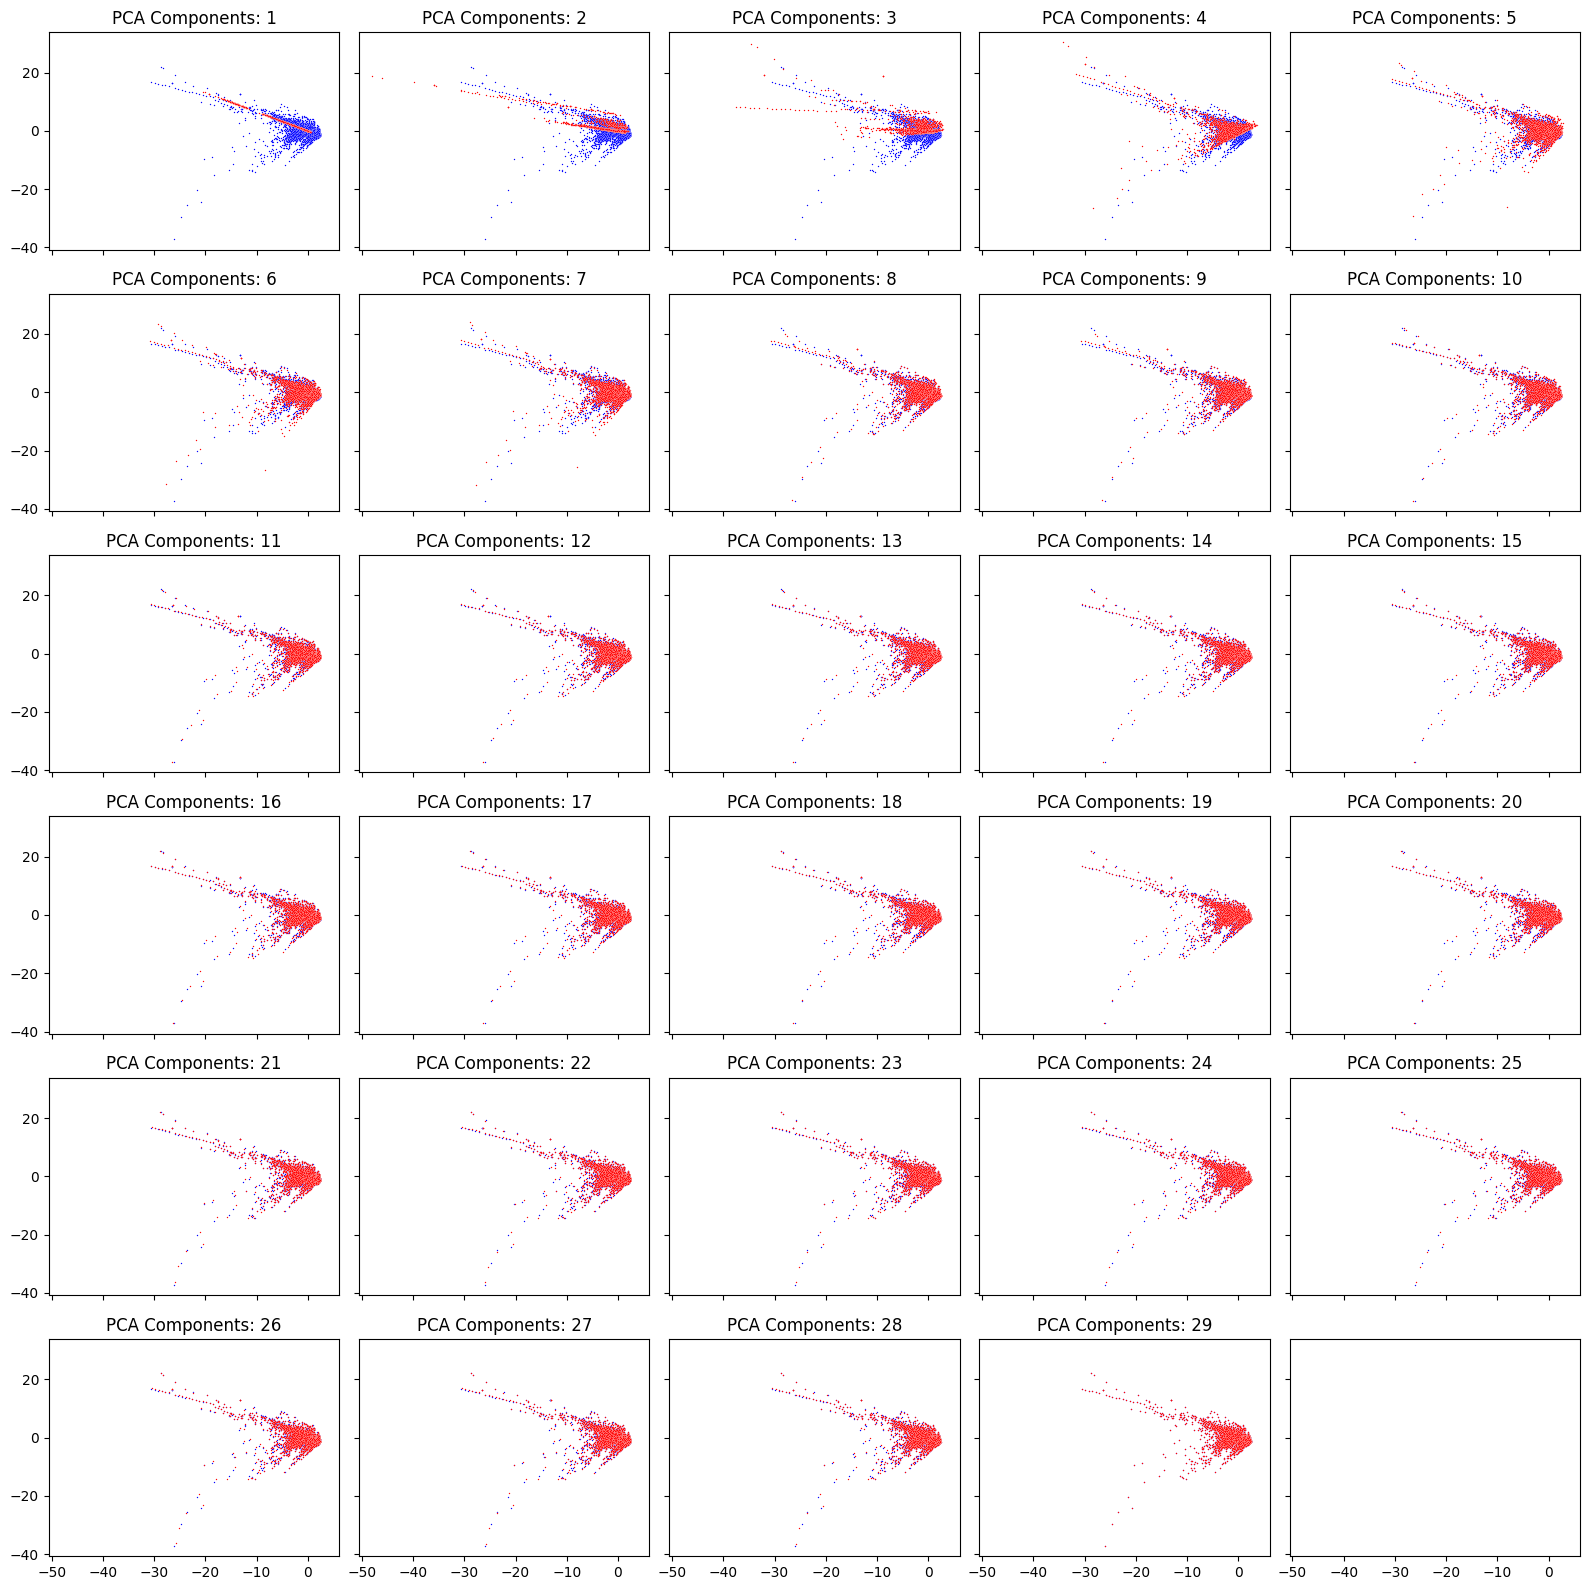

In [32]:
### Visualise the original data overlayered against the PCA inverse transform data:
## Define view parameters
rows = 6
cols = 5
comps = 1

## scaler = StandardScaler()
X_scaled = dfX.to_numpy()

fig, axes = plt.subplots(rows, 
                         cols, 
                         figsize=(16,16), 
                         sharex=True, 
                         sharey=True)

# Scatter of PCA (Black) and original (grey)  
for row in range(rows):
    for col in range(cols):
        try:
            X_new = transform_pca(X_scaled, comps)
            ax = sns.scatterplot(x=X_scaled[:, 0], 
                                 y=X_scaled[:, 1], 
                                 ax=axes[row, col], 
                                 color='blue', 
                                 s=1)
            ax = sns.scatterplot(x=X_new[:, 0], 
                                 y=X_new[:, 1], 
                                 ax=axes[row, col], 
                                 color='red',
                                 s=1)
            ax.set_title(f'PCA Components: {comps}');

            comps += 1
        except:
            pass
plt.tight_layout()

With 10 components we get 81% cumulitive variance - and the inverse transformation looks pretty good ... 

In [33]:
## 10 Component PCA dim reduction - from 29 dims  
pca = PCA(n_components=10)
pca.fit(dfX)
pcadfX = pca.transform(dfX)
print("Original shape: {}".format(str(dfX.shape)))
print("Reduced shape: {}".format(str(pcadfX.shape)))

Original shape: (10492, 29)
Reduced shape: (10492, 10)


In [48]:
dfY.describe()

,Time,Class
count,10492.000000,10492.000000
mean,0.001571,0.046893
std,0.994883,0.211419
min,-1.995720,0.000000
25%,-0.836755,0.000000
50%,-0.202953,0.000000
75%,0.929852,0.000000
max,1.641910,1.000000


In [54]:
df_pca = dfY[['Time', 'Class']].copy()
for n in range (0, 10):
    df_pca[f'PCA{n}'] = pcadfX[:,n]

## df_pca = pd.DataFrame(pcadfX, columns =['PCA1', 'PCA2', 'PCA3', 'PCA4', 'PCA5', 'PCA6', 'PCA7', 'PCA8', 'PCA9', 'PCA10'])
 
print(df_pca.describe())
print(df_pca.head())

               Time         Class          PCA0          PCA1          PCA2  \
count  10492.000000  10492.000000  1.049200e+04  1.049200e+04  10492.000000   
mean       0.001571      0.046893 -1.733692e-16  6.501344e-17      0.000000   
std        0.994883      0.211419  5.312121e+00  2.184223e+00      1.931501   
min       -1.995720      0.000000 -2.357209e+00 -1.692750e+01    -20.409616   
25%       -0.836755      0.000000 -1.213430e+00 -9.303205e-01     -0.406302   
50%       -0.202953      0.000000 -1.051880e+00 -2.192956e-01      0.094671   
75%        0.929852      0.000000 -7.096894e-01  6.470046e-01      0.448413   
max        1.641910      1.000000  6.206206e+01  3.777208e+01     39.859914   

               PCA3          PCA4          PCA5          PCA6          PCA7  \
count  1.049200e+04  1.049200e+04  1.049200e+04  1.049200e+04  1.049200e+04   
mean   2.708893e-17  1.083557e-17  1.083557e-17 -1.286724e-17 -2.167115e-17   
std    1.718996e+00  1.651898e+00  1.560479e+00  1.

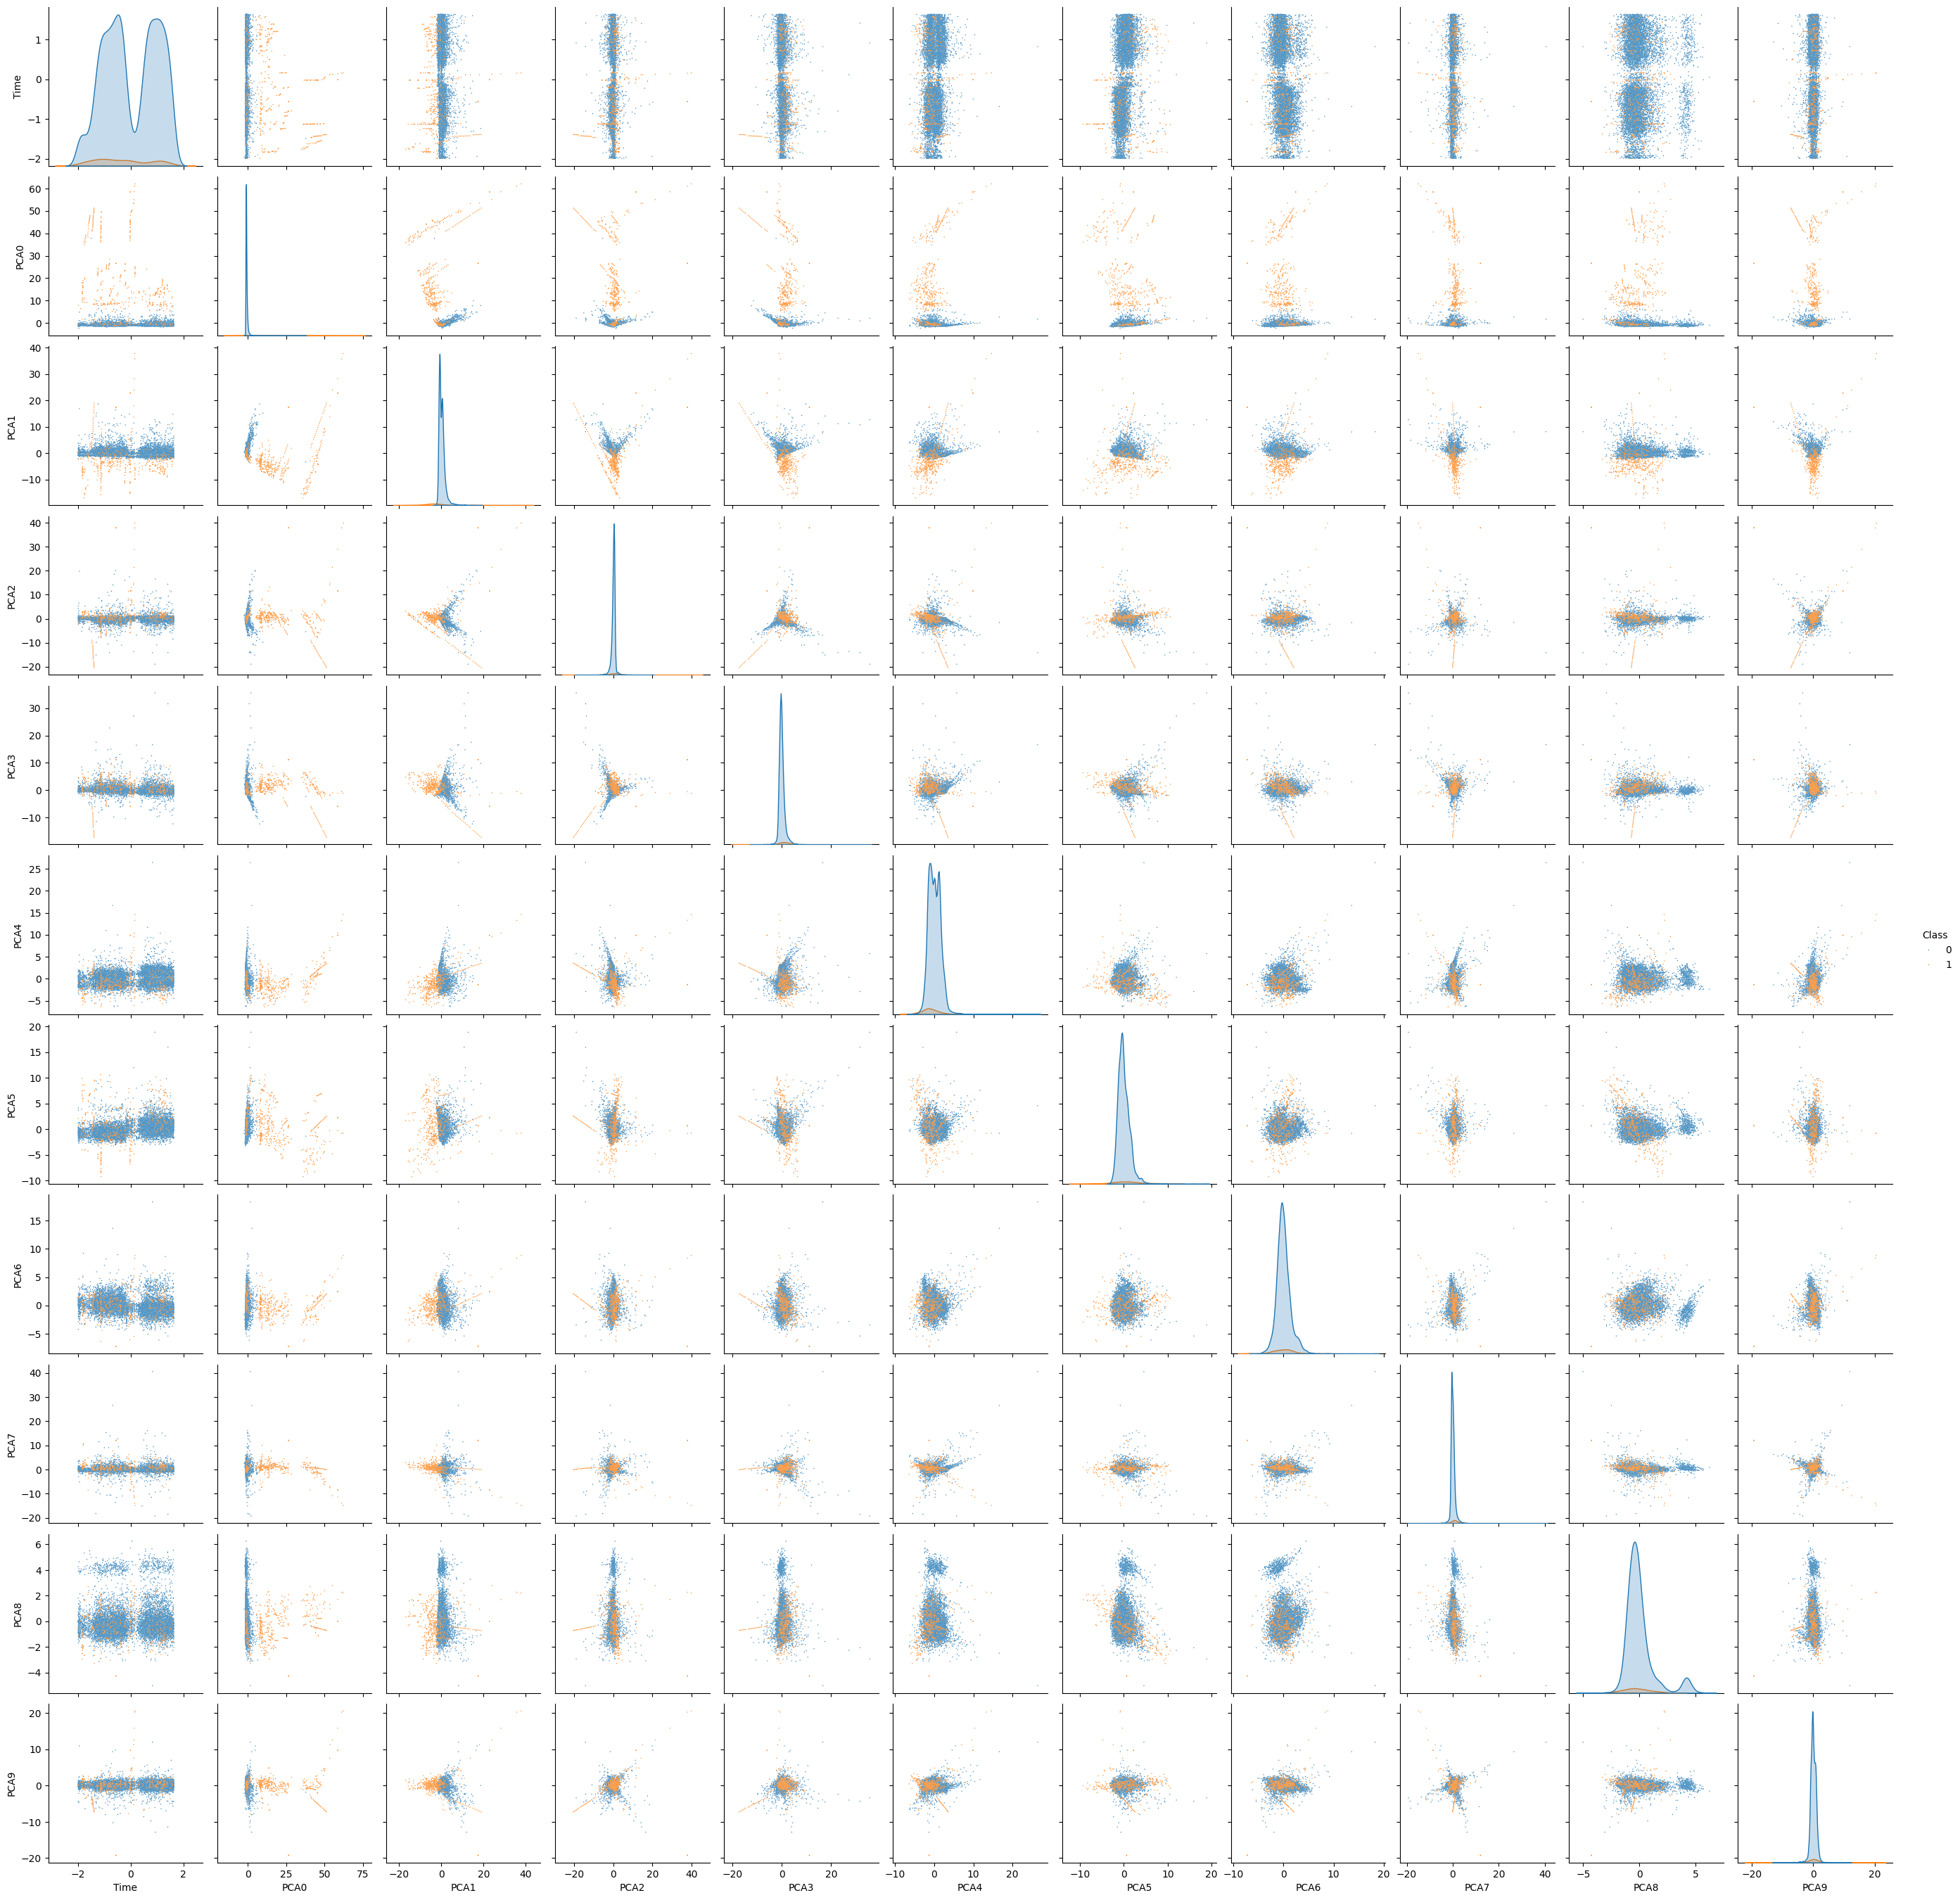

In [134]:
sns.pairplot(df_pca, hue='Class', plot_kws={'s': 1})

Visually, the first two Principle components are the ones that cause real seperation .... 

##### Creating the Training and Test datasets....

In [55]:
   

### Split the data 60:40 for train and test 
x_train, x_test = train_test_split(df_pca, test_size = 0.4, random_state = 42)
### Sort the data by standardised time: 
x_train = x_train.sort_values(by=['Time'])
x_test = x_test.sort_values(by=['Time'])
### Create y_train and y_test from the x_train and x_test - containing only the Class. 
y_train = x_train["Class"]
y_test = x_test["Class"]

x_train.head(10)

,Time,Class,PCA0,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9
60,-1.995720,0,-1.188214,-0.589273,0.120860,-0.210777,0.632260,0.315738,0.218144,-0.046982,-0.023879,0.308892
163,-1.994414,0,-1.156154,-0.842395,0.510121,-0.666199,-0.139410,-0.255520,0.836360,-0.600706,-0.889459,-0.011150
186,-1.993993,0,-1.223905,-0.603753,0.225279,-0.094437,0.852540,1.165744,0.254803,0.422144,4.263742,-0.280115
198,-1.993824,0,-0.700555,0.686222,-0.040621,-0.052571,-1.823625,-0.623338,1.329086,0.098998,0.007352,0.226050
327,-1.991550,0,-1.244275,-0.669428,0.221958,-0.313934,0.633441,-0.826124,0.148529,-0.420770,-0.055606,-0.440799
391,-1.990603,0,-0.760707,0.724136,-0.423697,-0.608843,-1.367190,-1.207351,0.335452,-0.078743,-0.846249,0.856711
459,-1.989508,0,-1.542950,0.356654,-0.079179,0.939078,-1.937843,-2.041916,-0.128197,0.639460,0.504745,0.328441
516,-1.988539,0,-1.083261,0.427234,-0.213078,0.671352,-1.309941,-1.371777,0.596495,0.063795,-0.453233,0.454400
556,-1.987865,0,-0.741262,1.534446,-0.032581,-0.488822,-0.432390,-1.221565,-2.290080,0.606613,-0.756451,0.687652
623,-1.986644,1,-0.557529,0.761177,-1.687766,4.600733,-1.006331,2.072803,1.528451,-0.634003,-1.078050,0.271336


In [56]:
### Create a and n datasets to assess class distribution of x .... 
a = x_train[x_train["Class"] == 1]
n = x_train[x_train["Class"] == 0]

a.shape, n.shape


((292, 12), (6003, 12))

In [57]:
a = x_test[x_test["Class"] == 1]
n = x_test[x_test["Class"] == 0]

a.shape, n.shape

((200, 12), (3997, 12))

492 datsets with class 1 (292:200), and 10000 datasets with class 0 (6003:3997)     
Note: all the anomalies are included in the train/test daatsets   

##### Assess the shape of the test and train datasets:

In [58]:
print("Shapes:\nx_train:%s\ny_train:%s\n" % (x_train.shape, y_train.shape))
print("x_test:%s\ny_test:%s\n" % (x_test.shape, y_test.shape))


Shapes:
x_train:(6295, 12)
y_train:(6295,)

x_test:(4197, 12)
y_test:(4197,)



##### Reshape the datasets - the X sets must be 3D, while the y sets should be 2D.      
Make the y sets categorical using keras.utils.to_categorical

In [59]:
### Reshape the x sets
x_train = np.array(x_train).reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = np.array(x_test).reshape(x_test.shape[0], x_test.shape[1], 1)
input_shape = (x_train.shape[1], 1)
### Categorise the y sets using keras.utils.to_categorical:
y_train = keras.utils.to_categorical(y_train, 2)
y_test = keras.utils.to_categorical(y_test, 2)


In [60]:
print("Shapes:\nx_train:%s\ny_train:%s\n" % (x_train.shape, y_train.shape))
print("x_test:%s\ny_test:%s\n" % (x_test.shape, y_test.shape))
print("input_shape:{}\n".format(input_shape))

Shapes:
x_train:(6295, 12, 1)
y_train:(6295, 2)

x_test:(4197, 12, 1)
y_test:(4197, 2)

input_shape:(12, 1)



##### Create the Diluted TCN model:     
Note: Dilation changes from 1, 2, 4, 8      
Padding is casual, and the activation is ReLu    
Interspaced with SpatialDropout1D    
Output layer uses softmax   

In [101]:

input_layer = Input(shape=(input_shape ))

#Series of temporal convolutional layers with dilations increasing by powers of 2.
conv_1 = Conv1D(filters=128, kernel_size=2, dilation_rate=1,
                padding='causal', strides=1,input_shape=input_shape,
                kernel_regularizer=regularizers.l2(0.01),
                activation='relu')(input_layer)

#Dropout layer after each 1D-convolutional layer
drop_1 = SpatialDropout1D(0.05)(conv_1)

conv_2 = Conv1D(filters=128, kernel_size=2, dilation_rate=2,
                padding='causal',strides=1, kernel_regularizer=regularizers.l2(0.01),
                activation='relu')(drop_1)

drop_2 = SpatialDropout1D(0.05)(conv_2)

conv_3 = Conv1D(filters=128, kernel_size=2, dilation_rate=4,
                padding='causal', strides=1,kernel_regularizer=regularizers.l2(0.01),
                activation='relu')(drop_2)

drop_3 = SpatialDropout1D(0.05)(conv_3)

conv_4 = Conv1D(filters=128, kernel_size=2, dilation_rate=8,
                padding='causal', strides=1,kernel_regularizer=regularizers.l2(0.05),
                activation='relu')(drop_3)

drop_4 = SpatialDropout1D(0.05)(conv_4)

#Flatten layer to feed into the output layer
flat = Flatten()(drop_4)
### Output layer outputting one of two classes. 
output_layer = Dense(2, activation='softmax')(flat)

TCN = Model(inputs=input_layer, outputs=output_layer)

##### Set-up the model as a function..... 

In [102]:
def call_existing_code(dilation_rate1, dilation_rate2, dilation_rate3, dilation_rate4, activation, filters):
    input_layer = Input(shape=(input_shape ))

    #Series of temporal convolutional layers with dilations increasing by powers of 2.
    conv_1 = Conv1D(filters=filters, kernel_size=2, dilation_rate=dilation_rate1,
                    padding='causal', strides=1,input_shape=input_shape,
                    kernel_regularizer=regularizers.l2(0.01),
                    activation=activation)(input_layer)

    #Dropout layer after each 1D-convolutional layer
    drop_1 = SpatialDropout1D(0.05)(conv_1)

    conv_2 = Conv1D(filters=filters, kernel_size=2, dilation_rate=dilation_rate2,
                    padding='causal',strides=1, kernel_regularizer=regularizers.l2(0.01),
                    activation=activation)(drop_1)

    drop_2 = SpatialDropout1D(0.05)(conv_2)

    conv_3 = Conv1D(filters=filters, kernel_size=2, dilation_rate=dilation_rate3,
                    padding='causal', strides=1,kernel_regularizer=regularizers.l2(0.01),
                    activation=activation)(drop_2)

    drop_3 = SpatialDropout1D(0.05)(conv_3)

    conv_4 = Conv1D(filters=filters, kernel_size=2, dilation_rate=dilation_rate4,
                    padding='causal', strides=1,kernel_regularizer=regularizers.l2(0.05),
                    activation=activation)(drop_3)

    drop_4 = SpatialDropout1D(0.05)(conv_4)

    #Flatten layer to feed into the output layer
    flat = Flatten()(drop_4)
    ### Output layer outputting one of two classes. 
    output_layer = Dense(2, activation='softmax')(flat)

    TCN = Model(inputs=input_layer, outputs=output_layer)
    return TCN

In [ ]:
def build_model(hp):
    filters = hp.Int("dilation_rate", min_value=64, max_value=192, step=32)
    dilation_rate1 = hp.Int("dilation_rate", min_value=1, max_value=4, step=1)
    dilation_rate2 = hp.Int("dilation_rate", min_value=2, max_value=8, step=2)
    dilation_rate3 = hp.Int("dilation_rate", min_value=2, max_value=12, step=2)
    dilation_rate4 = hp.Int("dilation_rate", min_value=4, max_value=20, step=4)
    activation = hp.Choice("activation", ["relu", "tanh"])

    # call existing model-building code with the hyperparameter values.
    model = call_existing_code(
        filters=filters, activation=activation, dilation_rate1=dilation_rate2, dilation_rate3, dilation_rate4
    )
    return model


##### Compile the TCN - loss is mse, optimizer is Adam, metrics output are 'mae', 'accuracy'            

In [103]:
TCN.compile(loss='mean_squared_error',
              optimizer=optimizers.Adam(lr=0.002),
              metrics=['mae', 'accuracy'])

checkpointer = ModelCheckpoint(filepath="model_TCN_creditcard.h5",
                               verbose=0,
                               save_best_only=True)

TCN.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 12, 1)]           0         
                                                                 
 conv1d_4 (Conv1D)           (None, 12, 128)           384       
                                                                 
 spatial_dropout1d_4 (Spati  (None, 12, 128)           0         
 alDropout1D)                                                    
                                                                 
 conv1d_5 (Conv1D)           (None, 12, 128)           32896     
                                                                 
 spatial_dropout1d_5 (Spati  (None, 12, 128)           0         
 alDropout1D)                                                    
                                                                 
 conv1d_6 (Conv1D)           (None, 12, 128)           3289

##### Fit the x_train and y_train data    
Note: Batch size is 128     
No of epochs is set to 7       
TensorBoard support is added in the callbacks      

In [104]:
#### Reduce the number of epochs to 7
TCN.fit(x_train, y_train,
          batch_size=64,
          epochs=7,
          verbose=1,
          validation_data=(x_test, y_test),
          callbacks = [TensorBoard(log_dir='../../logs/TCN1')])


Epoch 1/7


99/99 [==============================] - 14s 82ms/step - loss: 2.8539 - mae: 0.1516 - accuracy: 0.9584 - val_loss: 0.2949 - val_mae: 0.0685 - val_accuracy: 0.9755
Epoch 2/7
99/99 [==============================] - 6s 63ms/step - loss: 0.0951 - mae: 0.0687 - accuracy: 0.9787 - val_loss: 0.0371 - val_mae: 0.0601 - val_accuracy: 0.9764
Epoch 3/7
99/99 [==============================] - 6s 59ms/step - loss: 0.0332 - mae: 0.0595 - accuracy: 0.9847 - val_loss: 0.0330 - val_mae: 0.0527 - val_accuracy: 0.9757
Epoch 4/7
99/99 [==============================] - 7s 68ms/step - loss: 0.0292 - mae: 0.0548 - accuracy: 0.9873 - val_loss: 0.0281 - val_mae: 0.0547 - val_accuracy: 0.9893
Epoch 5/7
99/99 [==============================] - 6s 64ms/step - loss: 0.0288 - mae: 0.0540 - accuracy: 0.9862 - val_loss: 0.0268 - val_mae: 0.0463 - val_accuracy: 0.9893
Epoch 6/7
99/99 [==============================] - 6s 60ms/step - loss: 0.0267 - mae: 0.0492 - accuracy: 0.9875 - val_loss: 0.0264 - val_mae: 0.0424 

Epoch 1/7
 4/99 [>.............................] - ETA: 1s - loss: 0.0195 - mae: 0.0425 - accuracy: 0.9961

99/99 [==============================] - 6s 65ms/step - loss: 0.0247 - mae: 0.0484 - accuracy: 0.9895 - val_loss: 0.0246 - val_mae: 0.0454 - val_accuracy: 0.9888
Epoch 2/7
 1/99 [..............................] - ETA: 4s - loss: 0.0142 - mae: 0.0343 - accuracy: 1.0000

C:\Users\tanopsgeo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


99/99 [==============================] - 6s 59ms/step - loss: 0.0246 - mae: 0.0474 - accuracy: 0.9884 - val_loss: 0.0245 - val_mae: 0.0534 - val_accuracy: 0.9900
Epoch 3/7
99/99 [==============================] - 6s 59ms/step - loss: 0.0239 - mae: 0.0465 - accuracy: 0.9890 - val_loss: 0.0237 - val_mae: 0.0434 - val_accuracy: 0.9900
Epoch 4/7
99/99 [==============================] - 6s 59ms/step - loss: 0.0236 - mae: 0.0455 - accuracy: 0.9895 - val_loss: 0.0235 - val_mae: 0.0498 - val_accuracy: 0.9900
Epoch 5/7
99/99 [==============================] - 6s 60ms/step - loss: 0.0234 - mae: 0.0460 - accuracy: 0.9892 - val_loss: 0.0237 - val_mae: 0.0390 - val_accuracy: 0.9878
Epoch 6/7
99/99 [==============================] - 6s 61ms/step - loss: 0.0239 - mae: 0.0444 - accuracy: 0.9882 - val_loss: 0.0242 - val_mae: 0.0569 - val_accuracy: 0.9900
Epoch 7/7
99/99 [==============================] - 6s 61ms/step - loss: 0.0229 - mae: 0.0460 - accuracy: 0.9890 - val_loss: 0.0226 - val_mae: 0.0394 -

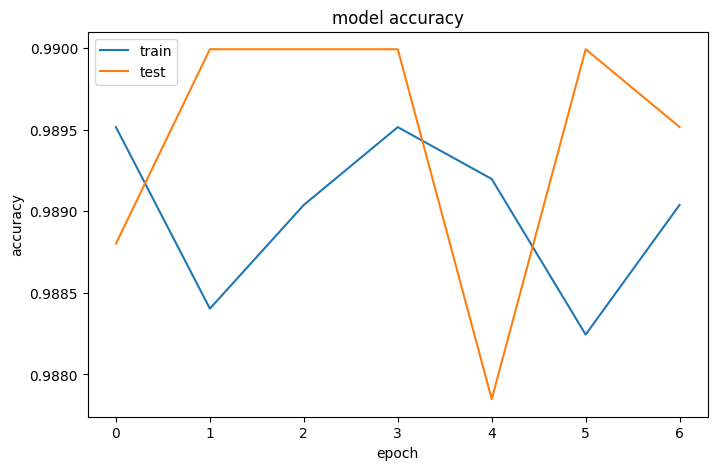

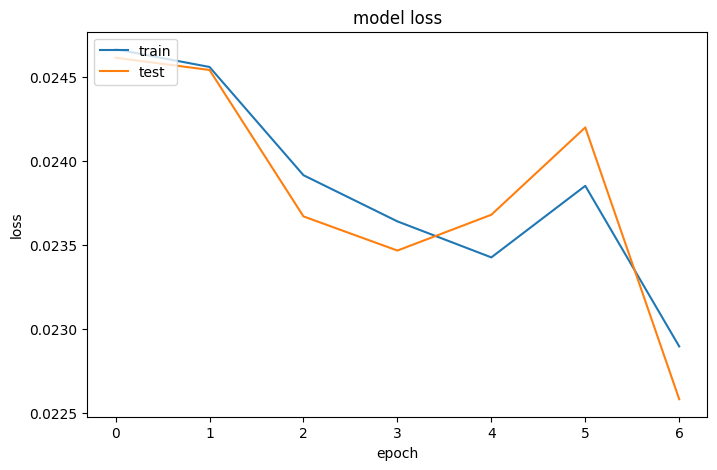

In [105]:
history = TCN.fit(x_train, y_train,
            batch_size=64,
            epochs=7,
            verbose=1,
            validation_data=(x_test, y_test),
            callbacks = [checkpointer])
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

The model is not really becoming more accurate with each epoch - although the loss is being reduced. 

##### Evaluate the model against the x_test and y_test data    

In [106]:

score = TCN.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.0225799810141325
Test accuracy: 0.03938431665301323


##### roc_auc_score - use the predicted y_pred against the actual y_test classes 

In [107]:
from sklearn.metrics import roc_auc_score

preds = TCN.predict(x_test)
### Round function uses a threshold of 0.5 ....
y_pred = np.round(preds)
print(y_pred)
auc = roc_auc_score( y_pred, y_test)
print("AUC: {:.2%}".format (auc))

132/132 [==============================] - 2s 14ms/step
[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]
AUC: 99.46%


In [148]:
print(y_test)

[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [108]:
print(preds[:,0], preds[:,1])

[0.9695469  0.97043276 0.97072953 ... 0.97637093 0.9768833  0.97070676] [0.03045312 0.02956726 0.02927041 ... 0.02362904 0.02311674 0.02929328]


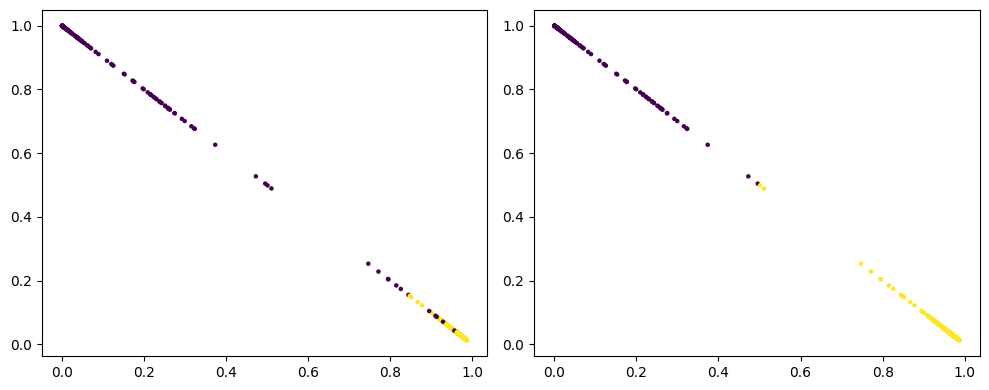

In [137]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].scatter(preds[:,0], preds[:,1], c=y_test[:,0], s=5)
axes[1].scatter(preds[:,0], preds[:,1], c=y_pred[:,0], s=5)
plt.tight_layout()
plt.show()


##### Using the PCA has produced a much clearer split between the classification


In [135]:
# Define a threshold for anomaly detection
threshold = 0.9 # Adjust this threshold as needed

# Assuming y_pred contains the model's predictions for the test data
# y_pred should be a list of values between 0 and 1 representing anomaly scores

# Create an array of 0s and 1s based on the threshold
anom_thresh = [1 if score > threshold else 0 for score in preds[:,0]]
# anomalies will now contain 1s for samples considered anomalies and 0s for non-anomalies

print(anom_thresh)
print(anom_thresh.count(0))

[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

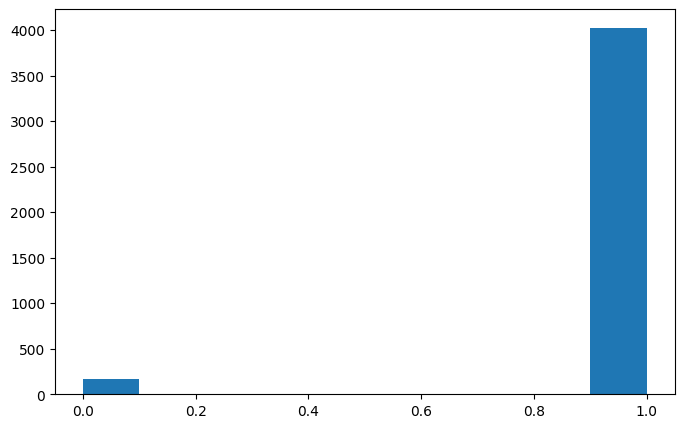

In [111]:
plt.hist(anom_thresh)
plt.show()

##### Test dataset has 200 anomalies to find ....

#### Change the threshold from 0.5 to 0.90 to see how this effects the confusion matrix .....

In [139]:
threshold = 0.9
### NumPy array called y_pred1 with the same shape and size as the y_test array:
y_pred1=np.zeros_like(y_test)
### Assigns a value of 1 to elements where the condition is True (i.e., where preds[:, 0] is greater than the threshold)
y_pred1[:,0] = np.where(preds[:,0] > threshold, 1, 0)

y_pred1[:,1] = np.where(preds[:,0] > (threshold), 0, 1)
print(y_pred1)

[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [140]:
print(classification_report(y_test, y_pred1))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      3997
           1       0.97      0.83      0.89       200

   micro avg       0.99      0.99      0.99      4197
   macro avg       0.98      0.91      0.95      4197
weighted avg       0.99      0.99      0.99      4197
 samples avg       0.99      0.99      0.99      4197



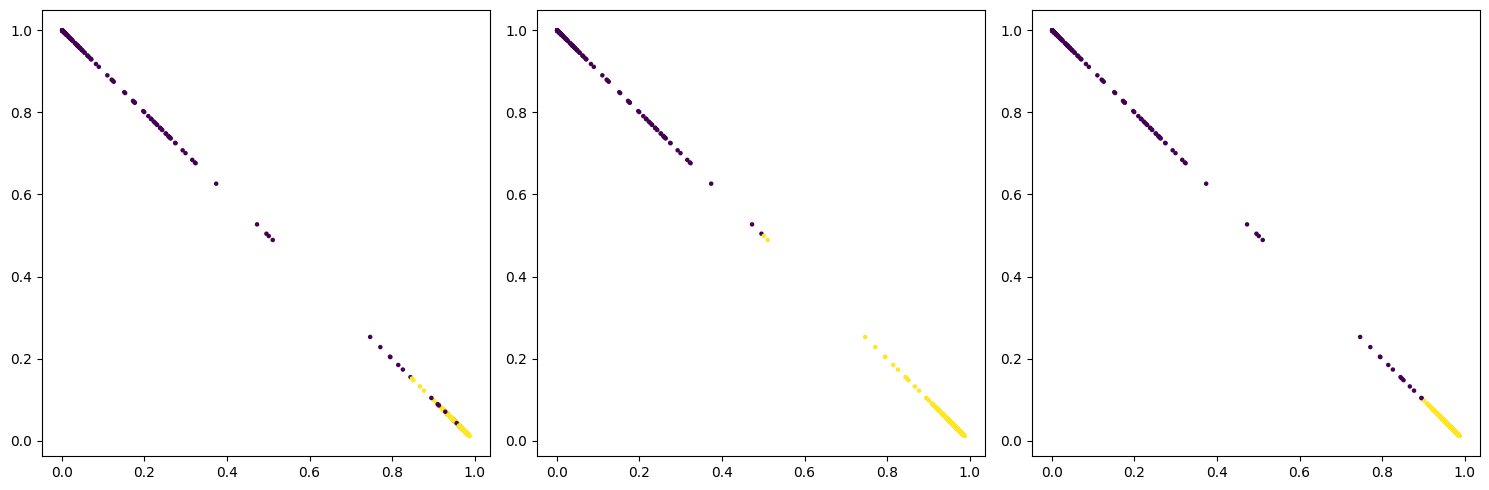

In [142]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].scatter(preds[:,0], preds[:,1], c=y_test[:,0], s=5)
axes[1].scatter(preds[:,0], preds[:,1], c=y_pred[:,0], s=5)
axes[2].scatter(preds[:,0], preds[:,1], c=y_pred1[:,0], s=5)
plt.tight_layout()
plt.show()

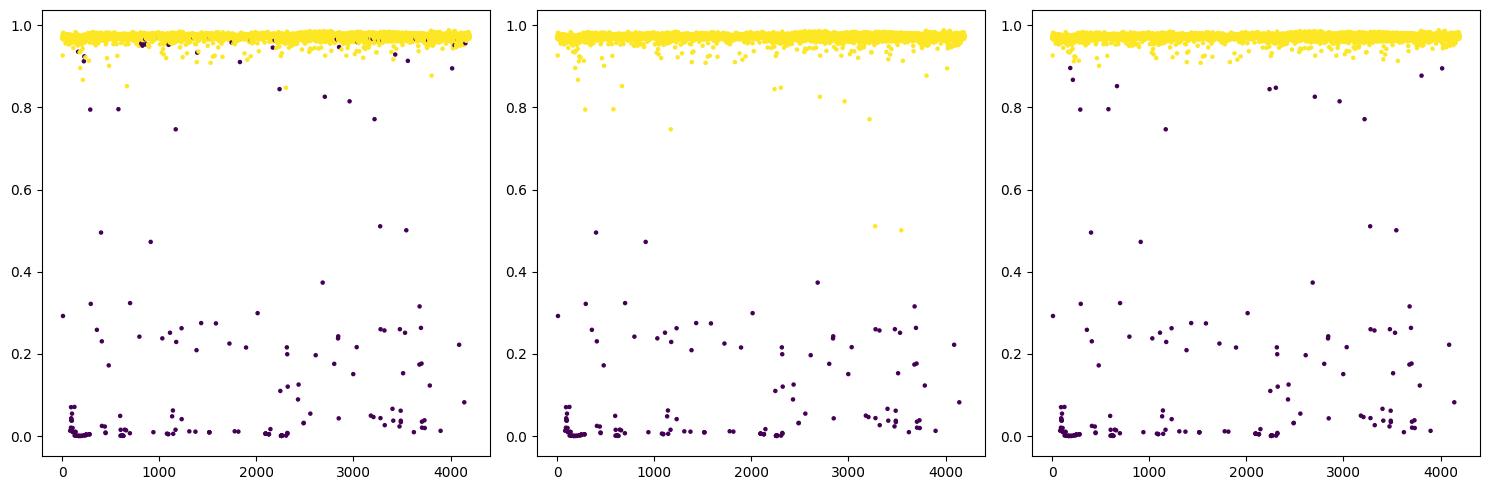

In [147]:
index = np.arange(len(preds))
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].scatter(index, preds[:,0], c=y_test[:,0], s=5)
axes[1].scatter(index, preds[:,0], c=y_pred[:,0], s=5)
axes[2].scatter(index, preds[:,0], c=y_pred1[:,0], s=5)
plt.tight_layout()
plt.show()

In [149]:
predictions = TCN.predict(x_test)

mse = np.mean(np.power(y_test - predictions, 2), axis=1)

print(mse.shape)
print(y_test.shape)

132/132 [==============================] - 1s 11ms/step
(4197,)
(4197, 2)


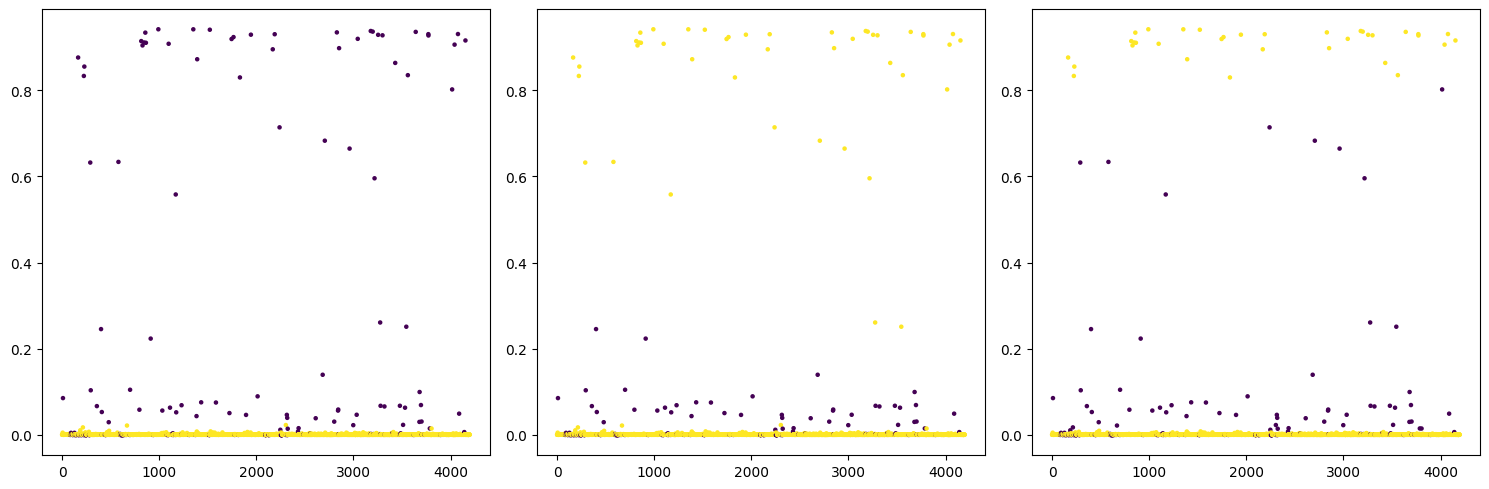

In [152]:
index = np.arange(len(preds))
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].scatter(index, mse, c=y_test[:,0], s=5)
axes[1].scatter(index, mse, c=y_pred[:,0], s=5)
axes[2].scatter(index, mse, c=y_pred1[:,0], s=5)
plt.tight_layout()
plt.show()

### Set the threshold based on mse .....      
Maybe set up the threshold with an mse above 0.05 ..... 

In [169]:
threshold = 0.05
### NumPy array called y_pred1 with the same shape and size as the y_test array:
y_pred3=np.zeros_like(y_test)
### Assigns a value of 1 to elements where the condition is True (i.e., where preds[:, 0] is greater than the threshold)
y_pred3[:,0] = np.where(mse < threshold, 1, 0)

y_pred3[:,1] = np.where(mse < threshold, 0, 1)
print(y_pred3)

[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]


##### Visualisation - first up the confusion matrix. 

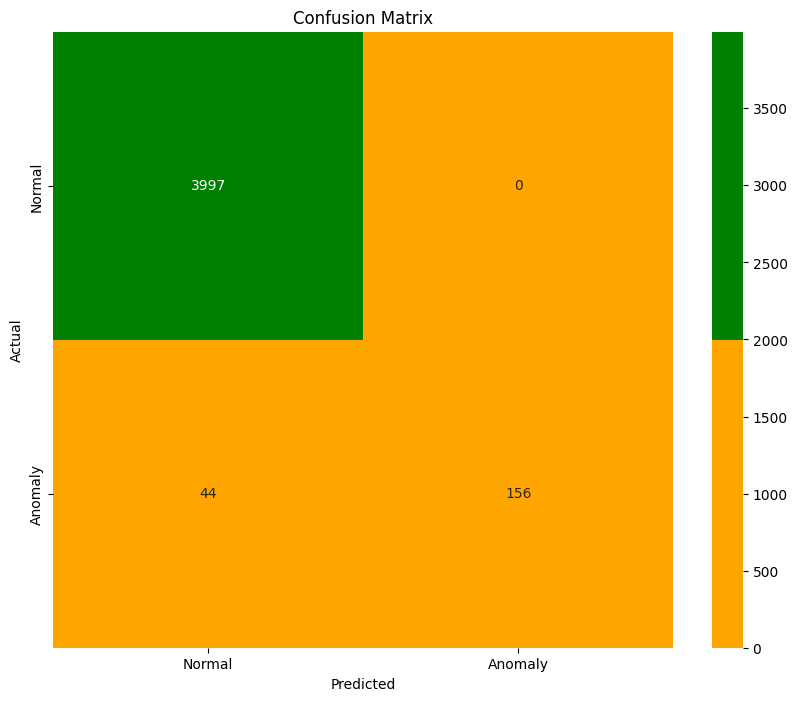

In [126]:
viz = Visualization()
y_pred2 = np.argmax(y_pred, axis=1)
y_test2 = np.argmax(y_test, axis=1)
viz.draw_confusion_matrix(y_test2, y_pred2)

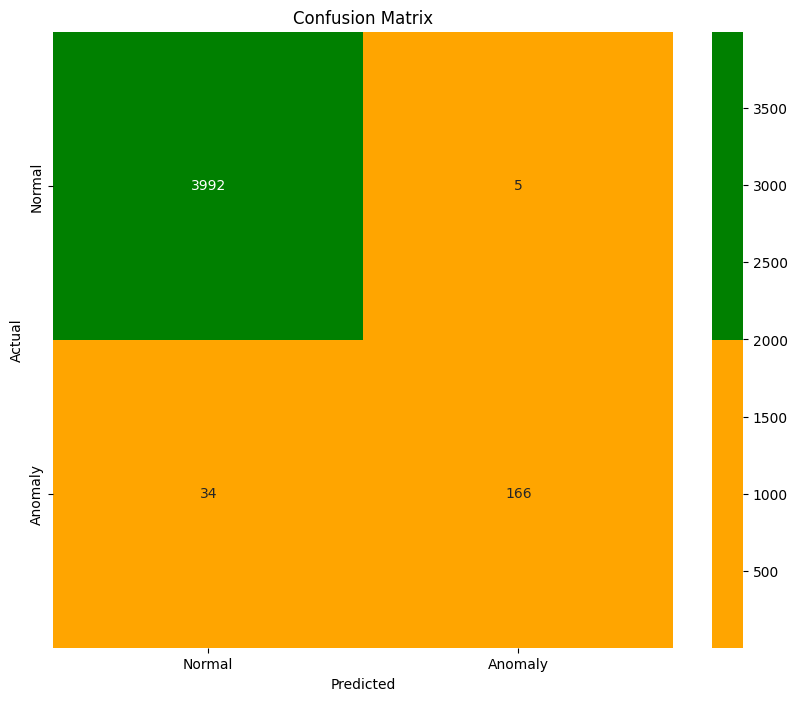

In [127]:
viz = Visualization()
y_pred2 = np.argmax(y_pred1, axis=1)
y_test2 = np.argmax(y_test, axis=1)
viz.draw_confusion_matrix(y_test2, y_pred2)


##### At threshold 0.5 - Only 158 of the 198 anomalies were accurately classified - but 42 were incorrectly classified 

##### At threshold 0.875 - 165 anomalies were accurately classified - but 35+4 were incorrect 

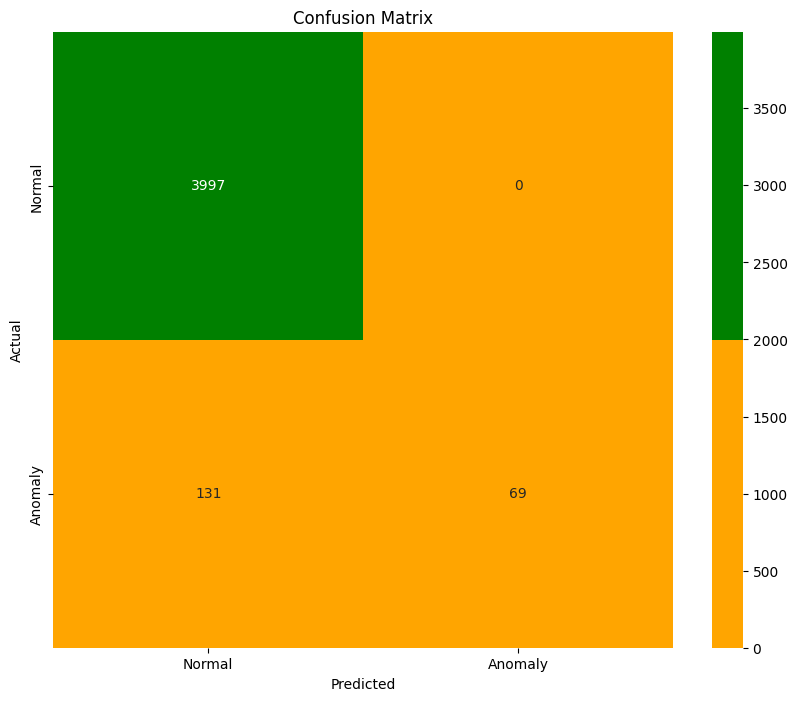

In [170]:
viz = Visualization()
y_pred2 = np.argmax(y_pred3, axis=1)
y_test2 = np.argmax(y_test, axis=1)
viz.draw_confusion_matrix(y_test2, y_pred2)

##### Using MSE doesn't work as well as predicted outcome.  

In [143]:
predictions = TCN.predict(x_test)

mse = np.mean(np.power(y_test - predictions, 2), axis=1)

print(mse.shape)
print(y_test.shape)

 18/132 [===>..........................] - ETA: 0s

132/132 [==============================] - 1s 7ms/step
(4197,)
(4197, 2)


In [144]:
## error_df = pd.DataFrame({'reconstruction_error': mse,
##                       'true_class': y_test}, index=[0])
error_df = pd.DataFrame({'reconstruction_error': mse,
                         'true_class': y_test[:,0]})

error_df.describe()

,reconstruction_error,true_class
count,4.197000e+03,4197.000000
mean,1.023146e-02,0.952347
std,8.671307e-02,0.213057
min,1.334870e-07,0.000000
25%,5.672431e-04,1.000000
50%,7.320538e-04,1.000000
75%,9.725295e-04,1.000000
max,9.408690e-01,1.000000


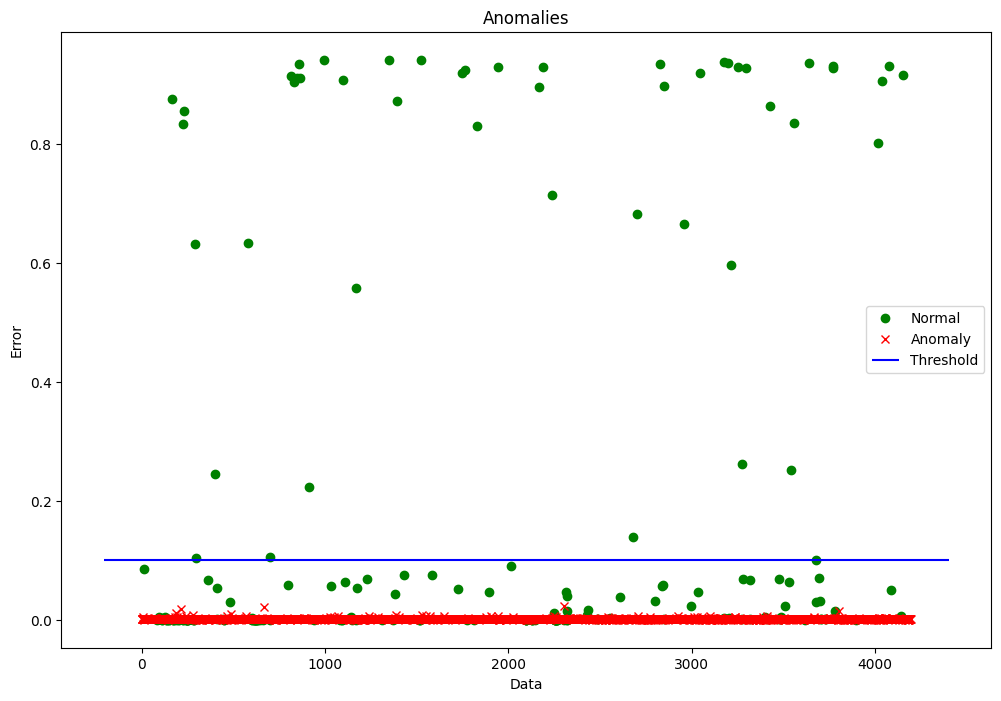

In [145]:
#### threshold = 0.5
viz.draw_anomaly(error_df['true_class'], error_df['reconstruction_error'], 0.1)

In [ ]:
def draw_anomaly(y, error, threshold):
        groupsDF = pd.DataFrame({'error': error,
                                 'true': y}).groupby('true')

        figure, axes = plt.subplots(figsize=(12, 8))

        for name, group in groupsDF:
            axes.plot(group.index, group.error, marker='x' if name == 1 else 'o', linestyle='',
                    color='r' if name == 1 else 'g', label="Anomaly" if name == 1 else "Normal")

        axes.hlines(threshold, axes.get_xlim()[0], axes.get_xlim()[1], colors="b", zorder=100, label='Threshold')
        axes.legend()
        
        plt.title("Anomalies")
        plt.ylabel("Error")
        plt.xlabel("Data")
        plt.show()